In [1]:
from google.colab import files
files.upload() # kaggle.jsonをアップロード
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


  0% 0.00/11.9M [00:00<?, ?B/s]
100% 11.9M/11.9M [00:00<00:00, 110MB/s]
Archive:  eeg-brainwave-dataset-feeling-emotions.zip
  inflating: emotions.csv            
2132
2132 2132

 LDAで次元削減(次元数:2) 
[-29.40646781  -8.8174226 ]
Accuracy: 0.81
              precision    recall  f1-score   support

    POSITIVE       0.75      0.74      0.74       280
    NEGATIVE       0.84      0.75      0.79       290
     NEUTRAL       0.83      0.95      0.89       283

    accuracy                           0.81       853
   macro avg       0.81      0.81      0.81       853
weighted avg       0.81      0.81      0.81       853



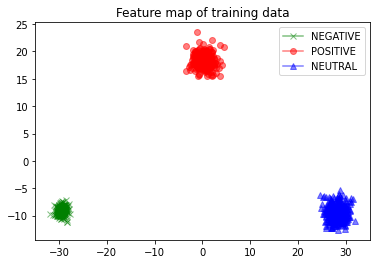

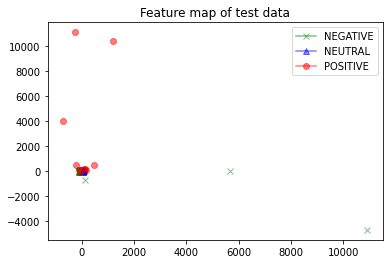

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis \
import LinearDiscriminantAnalysis
from sklearn.metrics \
import accuracy_score, classification_report

# データの準備
def prepare():
    !kaggle datasets download -d \
    birdy654/eeg-brainwave-dataset-feeling-emotions
    !unzip eeg-brainwave-dataset-feeling-emotions.zip
    data, labs, features = [], [], []
    data = pd.read_csv('emotions.csv')
    print(len(data))
    for f in data.columns.values[:-1]:
        features.append(f)
    labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
    lbmp = {'POSITIVE':0, 'NEGATIVE':1, 'NEUTRAL':2}
    data['label'].replace(lbmp, inplace=True)
    X_train = data.loc[:, features].values
    y_train = data.loc[:, ['label']].values.ravel()
    print(len(X_train), len(y_train))
    return X_train, y_train, labels

# 欠損値の補完、標準化
def preprocess(x):
    # 単一代入法
    simple_imp = SimpleImputer(missing_values=np.nan, 
  strategy='mean')
    simple_imp.fit( x )
    x_imp = simple_imp.transform(x)
    sc = StandardScaler()
    x_std = sc.fit_transform(x_imp)
    return x_std

# 最適な特徴量の数を決定する
# object_varは、目標とする寄与率の合計
def select_feature_count(var_ratio, object_var):
    # 累積寄与率を格納する変数
    variance = 0.0 
    # 選択された特徴量の数をカウント
    n_comp = 0 
    for explained_var in var_ratio:
        variance += explained_var
        n_comp += 1
        if variance > object_var:
            break
    return n_comp

# 特徴量を2次元平面上に写像
def disp_feature_map(X_data, y_data, labels, flag):
    plt.figure()
    label_list = [labels[int(y)] % y for y in y_data]
    mks = ['o', 'x', '^']
    col = ['r', 'g', 'b']
    lc = [0] * len(labels)
    for (dim1, dim2, label) in zip(X_data[:,0],X_data[:,1],
   label_list):
        idx = labels.index(label)
        if lc[labels.index(label)] == 0:
            plt.plot(dim1, dim2, marker=mks[idx],c=col[idx],
   label=label, alpha=0.5)
        else:
            plt.plot(dim1, dim2, marker=mks[idx], 
  c=col[idx], alpha=0.5)
        lc[idx] += 1
    plt.legend()
    plt.title('Feature map of {} data'.format(flag))
    plt.savefig('FeatureMap_{}.png'.format(flag), dpi=500)
    plt.show()

def main():
    n_class = 3
    X_train, y_train, labels = prepare()
    X_train_std = preprocess(X_train)
    X_train_std, X_test_std, y_train, y_test =\
    train_test_split(
X_train_std, y_train, train_size=0.6, random_state=1)
    # n_componentsにNoneを指定する
    lda = LinearDiscriminantAnalysis(n_components=None)
    lda_feature = lda.fit(X_train_std, y_train)
    # 寄与率の配列を取得 
    lda_contribution_rates = lda.explained_variance_ratio_
    # 特徴量の数を求める
    # 目標とする寄与率の合計を0.97とする
    n_components = select_feature_count(
  lda_contribution_rates, 0.97)
    print('\n LDAで次元削減(次元数:%d) ' % (n_components))
    # 得られた次元数を用いて次元削減を行う
    lda = LinearDiscriminantAnalysis(
                             n_components=n_components)
    X_train_lda = lda.fit_transform(X_train_std, y_train)
    print(X_train_lda[0])
    X_test_lda = lda.transform(X_test_std)
    lda.fit(X_train_lda, y_train)
    y_pred = lda.predict(X_test_lda)
    print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))
    print(classification_report(y_test, y_pred,
   target_names=labels))
    disp_feature_map(X_train_lda, y_train, labels, 'training')
    disp_feature_map(X_test_lda, y_test, labels,'test')

if __name__ == '__main__':
    main()
